In [62]:
import pandas as pd
from PIL import Image, ImageDraw
import numpy as np
import random
import math


Etape 1 : Vérifiaction CSV

In [49]:
import pandas as pd

def normaliser_csv(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adapte automatiquement un CSV hétérogène au format attendu :
    - Identifie les colonnes numériques et textuelles
    - Renomme selon le modèle attendu : Categorie / Coordonnees / Couleur
    - Réordonne les colonnes pour le pipeline graphique
    """

    # Nettoyer les noms de colonnes (minuscules + suppression des espaces)
    df.columns = [col.strip().lower() for col in df.columns]

    # Détecter colonnes numériques et textuelles
    colonnes_num = df.select_dtypes(include=["number"]).columns.tolist()
    colonnes_text = df.select_dtypes(exclude=["number"]).columns.tolist()

    # Vérifications
    if len(colonnes_text) < 1 or len(colonnes_num) < 2:
        raise ValueError("Le CSV doit contenir au moins une colonne texte et deux colonnes numériques.")

    # Choix intelligent :
    # - La première colonne texte devient "Categorie"
    # - La première colonne numérique devient "Coordonnees"
    # - La dernière colonne numérique devient "Couleur"
    cat_col = colonnes_text[0]
    coord_col = colonnes_num[0]
    color_col = colonnes_num[-1]

    # Création du DataFrame homogène
    df_normalise = pd.DataFrame({
        "Categorie": df[cat_col],
        "Coordonnees": df[coord_col],
        "Couleur": df[color_col]
    })

    return df_normalise


Import CSV

In [56]:
df = pd.read_csv("data_test.csv",sep=";")
df = normaliser_csv(df)
print(df.head())


  Categorie  Coordonnees  Couleur
0      Avec          289       74
1      Avec           30      146
2      Avec          127       93
3      Avec          132      114
4      Avec          113      235


Étape 2 : Créer le canevas et préparer la fonction pour générer les courbes

In [57]:
# Paramètres du canvas
LARGEUR = 800
HAUTEUR = 600

# Couleurs de début et fin du dégradé (haut -> bas)
couleur_haut = (30, 30, 60)   # bleu foncé
couleur_bas = (80, 20, 40)    # violet rougeâtre

# Créer l'image vierge
image = Image.new("RGB", (LARGEUR, HAUTEUR), (0, 0, 0))
draw = ImageDraw.Draw(image)

# Générer le dégradé vertical
for y in range(HAUTEUR):
    ratio = y / (HAUTEUR - 1)
    r = int(couleur_haut[0] * (1 - ratio) + couleur_bas[0] * ratio)
    g = int(couleur_haut[1] * (1 - ratio) + couleur_bas[1] * ratio)
    b = int(couleur_haut[2] * (1 - ratio) + couleur_bas[2] * ratio)
    draw.line([(0, y), (LARGEUR, y)], fill=(r, g, b))


In [58]:
for _, row in df.iterrows():
    x = 50  # départ gauche
    y = random.randint(50, HAUTEUR-50)
    longueur = 150 + row["Coordonnees"]
    amplitude = 20 + row["Coordonnees"] / 10
    couleur_base = int(row["Couleur"])
    draw_curve_with_gradient(draw, x, y, longueur, amplitude, couleur_base)


Étape 3 : Définir une fonction pour dessiner une courbe avec un dégradé

In [59]:
def draw_curve_with_gradient(draw, x, y, longueur, amplitude, couleur_base):
    """
    Dessine une courbe ondulée horizontale (gauche → droite) avec un dégradé de couleur.
      
    Args:
        draw : objet ImageDraw
        x, y : position de départ (à gauche)
        longueur : longueur horizontale
        amplitude : amplitude verticale
        couleur_base : valeur de la couleur (0-255)
    """
    points = []
    nb_points = 50  # nombre de points sur la courbe
    
    for i in range(nb_points + 1):
        t = i / nb_points
        px = x + t * longueur           # mouvement horizontal (gauche → droite)
        py = y + amplitude * np.sin(2 * np.pi * t)  # ondulation verticale
        points.append((px, py))
    
    # Dégradé de couleur le long de la courbe
    for i in range(len(points)-1):
        ratio = i / (len(points)-1)
        couleur = (
            int(couleur_base * (1-ratio) + 50*ratio),  # R
            int(200 * (1-ratio) + couleur_base*ratio), # G
            int(255 * ratio),                           # B
            180                                         # alpha
        )
        draw.line([points[i], points[i+1]], fill=couleur, width=4)


Étape 4 : Parcourir les lignes du CSV et dessiner les courbes

In [60]:
for _, row in df.iterrows():
    # Position X selon Coordonnees, Y aléatoire
    x = int(row["Coordonnees"] * LARGEUR / 200)
    y = random.randint(50, HAUTEUR-200)
    
    # Longueur et amplitude de la courbe selon Coordonnees et Categorie
    longueur = 150 + random.randint(-30, 30)
    amplitude = 20 + row["Coordonnees"] / 10  # plus la coordonnée est grande, plus l'ondulation est large
    
    # Couleur base
    couleur_base = int(row["Couleur"])
    
    # Dessiner la courbe
    draw_curve_with_gradient(draw, x, y, longueur, amplitude, couleur_base)


Étape 5 : Sauvegarder et afficher l’image dans le notebook

✅ Image générée : oeuvre_courbes.png


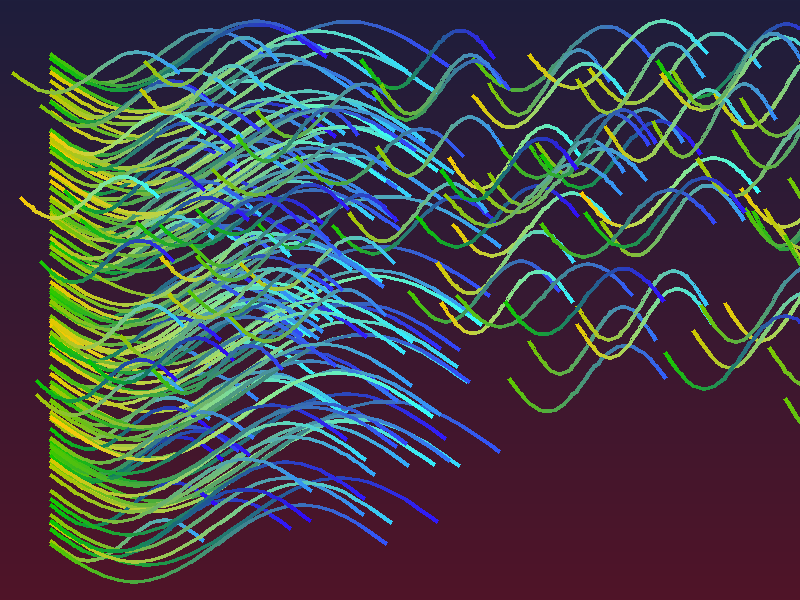

In [61]:
# Sauvegarde de l'image
output_path = "oeuvre_courbes.png"
image.save(output_path)
print(f"✅ Image générée : {output_path}")

# Affichage dans le notebook
from IPython.display import display
display(image)
